In [1]:
from datetime import date
from pathlib import Path

import aiohttp
import aiomoex
import matplotlib.pyplot as plt
import pandas as pd
from aiomoex import client
from aiomoex.request_helpers import make_url, get_table, make_query
import datatable as dt
from datatable import f

from glob import glob
import seaborn as sns

from parsing.commodities import get_brent_history, __COMMODITIES_FOLDER__

In [2]:
PREFIX = 'BR'
MONTHS = ('F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X', 'Z')
YEARS = range(0, 10)

In [3]:
for month in MONTHS:
    for year in YEARS:
        security = PREFIX + month + str(year)

        url = make_url(engine="futures", market="forts", board="RFUD", security=security, history=True)
        query = make_query(start='2016-01-01', end='2022-01-01')

        async with aiohttp.ClientSession() as session:
            iss = client.ISSClient(session, url, query)

            data = await iss.get_all()
            history = get_table(data, "history")
            if len(history) == 0:
                continue

            bond_df = pd.DataFrame(history)
            bond_df.to_csv(str(__COMMODITIES_FOLDER__.joinpath('history', security + '.csv')), header=True, index=False)


In [4]:
DT = get_brent_history()

In [5]:
DT.to_pandas()

,BOARDID,TRADEDATE,SECID,OPEN,LOW,HIGH,CLOSE,OPENPOSITIONVALUE,VALUE,VOLUME,OPENPOSITION
0,RFUD,2019-09-25,BRV0,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
1,RFUD,2019-09-26,BRV0,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
2,RFUD,2019-09-27,BRV0,59.13,59.13,59.13,59.13,1.509958e+05,7.611580e+04,2.0,4.0
3,RFUD,2019-09-30,BRV0,59.40,56.79,59.40,56.79,1.512868e+05,7.539035e+04,2.0,4.0
4,RFUD,2019-10-01,BRV0,NaN,NaN,NaN,NaN,1.507763e+05,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...
17726,RFUD,2016-10-27,BRX6,50.09,49.66,50.77,50.60,1.407277e+10,6.115958e+10,1938058.0,443120.0
17727,RFUD,2016-10-28,BRX6,50.69,49.91,50.88,49.97,1.425438e+10,4.075412e+10,1286571.0,453356.0
17728,RFUD,2016-10-31,BRX6,50.00,48.05,50.13,48.16,7.888373e+09,4.041177e+10,1292924.0,258312.0
17729,RFUD,2016-11-01,BRX6,48.22,47.96,48.34,48.32,0.000000e+00,9.307155e+09,305863.0,0.0


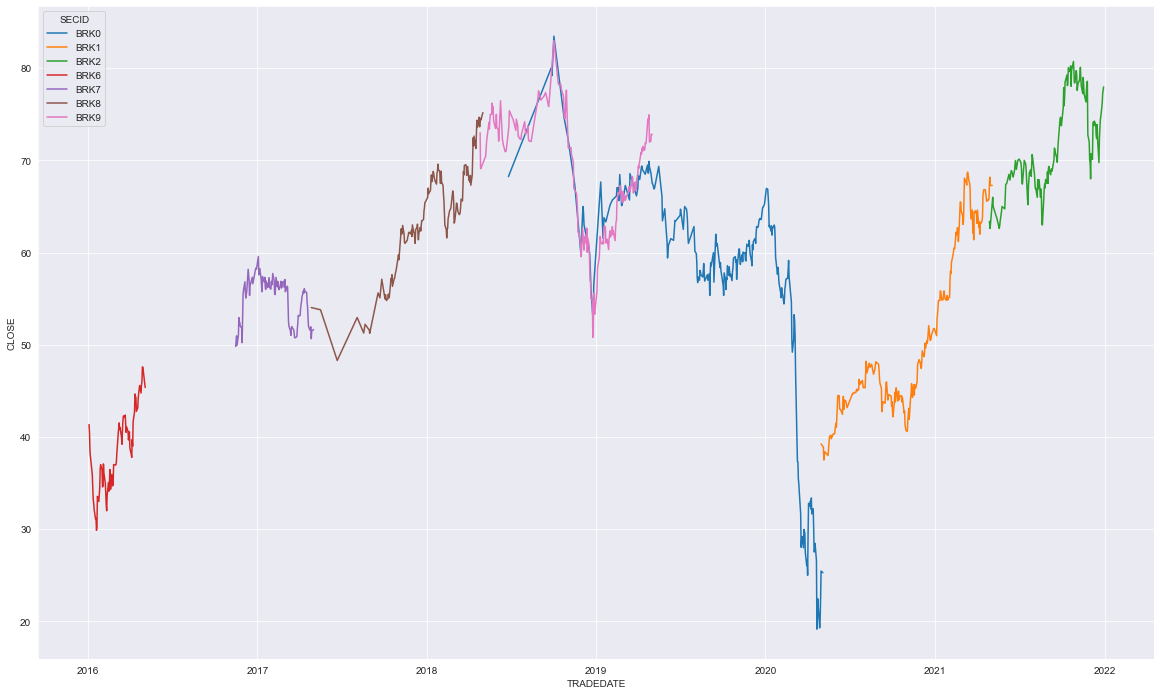

In [6]:
all_dec = [PREFIX + 'K' + str(y) for y in YEARS]
df: pd.DataFrame = DT[:, ['TRADEDATE', 'CLOSE'], dt.by('SECID')].to_pandas()
only_dec = df[df['SECID'].isin(pd.Series(all_dec))]

sns.lineplot(data=only_dec, x='TRADEDATE', y='CLOSE', hue='SECID')
plt.gcf().set_size_inches(20, 12)

In [7]:
all_futures = dt.unique(DT['SECID']).to_list()[0]

In [8]:
columns = ['SECID', 'LASTDELDATE']
brent_info = pd.DataFrame(columns=columns).set_index('SECID')

for security in all_futures:
    url = make_url(engine="futures", market="forts", board="RFUD", security=security, history=False)
    query = make_query(columns=columns, table='securities')

    async with aiohttp.ClientSession() as session:
        iss = client.ISSClient(session, url, query)

        data = await iss.get()
        info = get_table(data, "securities")
        if len(info) == 0:
            continue

        info_df = pd.DataFrame(info).set_index('SECID')
        brent_info = brent_info.append(info_df)


In [49]:
DT_1 = DT[:, {'LASTDELDATE': dt.max(dt.f.TRADEDATE)}, dt.by('SECID')]
shifted = DT_1[:,:, dt.sort('LASTDELDATE')].to_pandas().shift(-2)
shifted['BUYDATE'] = shifted['LASTDELDATE'].shift(2)
shifted.iloc[0, shifted.columns.get_loc('BUYDATE')] = '2016-01-04'
result = shifted.dropna()
result = result[result['BUYDATE'] < '2021-12-30']

concatenated = pd.DataFrame(columns=DT.names)

for _, row in result.iterrows():
    lastdate = date(row['LASTDELDATE'].year, row['LASTDELDATE'].month, row['LASTDELDATE'].day)
    buydate = date(row['BUYDATE'].year, row['BUYDATE'].month, row['BUYDATE'].day)
    filtered = DT[(dt.f.SECID == row['SECID']) & (dt.f.TRADEDATE < dt.Frame([lastdate])) & (dt.f.TRADEDATE >= dt.Frame([buydate])), :]
    concatenated = concatenated.append(filtered.to_pandas())

concatenated.drop_duplicates(subset=['TRADEDATE']).dropna().set_index('TRADEDATE')

,BOARDID,SECID,OPEN,LOW,HIGH,CLOSE,OPENPOSITIONVALUE,VALUE,VOLUME,OPENPOSITION
TRADEDATE,,,,,,,,,,
2016-01-04,RFUD,BRH6,38.00,37.70,40.16,39.54,5.381721e+08,1.570905e+08,5527.0,18704.0
2016-01-05,RFUD,BRH6,39.30,37.70,39.30,37.70,6.439078e+08,1.562436e+08,5552.0,23208.0
2016-01-06,RFUD,BRH6,37.93,35.85,38.20,35.91,6.713526e+08,1.723653e+08,6297.0,25168.0
2016-01-11,RFUD,BRH6,35.91,33.87,36.23,33.95,6.358517e+08,2.692230e+08,10320.0,24746.0
2016-01-12,RFUD,BRH6,33.90,31.92,33.90,32.40,6.893546e+08,4.203436e+08,16773.0,27822.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,RFUD,BRF2,74.38,74.20,75.79,75.63,5.194925e+10,8.084635e+10,1461187.0,935022.0
2021-12-24,RFUD,BRF2,75.63,75.57,77.02,75.85,5.136042e+10,6.654017e+10,1183904.0,916922.0
2021-12-27,RFUD,BRF2,75.75,75.70,78.29,78.15,2.085039e+10,8.105871e+10,1442834.0,362766.0


KeyboardInterrupt: 

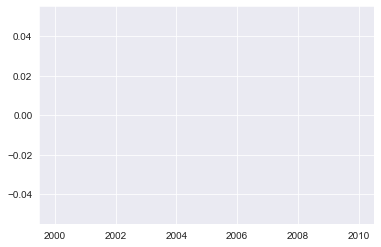

In [52]:
sns.lineplot(data=concatenated, x='TRADEDATE', y='CLOSE', hue='SECID')
plt.gcf().set_size_inches(20, 12)